In [141]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import control as ct
from control.matlab import *

In [142]:
def getModeloMinimo(p_1: float, p_2: float, p_3: float, g_e: float, i_e: float):
    
    def modeloMinimoStateUpdateFun(t, c, u, params):
        p_1 = params["p_1"]
        p_2 = params["p_2"]
        p_3 = params["p_3"]
        g_e = params["g_e"]
        i_e = params["i_e"]
        
        dc_0 = -p_1*c[0] + c[1]*c[0] + p_1*g_e
        
        dc_1 = -p_2*c[1] + p_3*(u[0]-i_e)
        dc_dt = np.array([dc_0, dc_1]).reshape(-1)
        return dc_dt
    
    def modeloMinimoStateOutputFun(t, c, u, params):
        return c
    
    params_dict = {
        "p_1": p_1,
        "p_2": p_2,
        "p_3": p_3,
        "g_e": g_e,
        "i_e": i_e
    }
    
    system = ct.NonlinearIOSystem(
        updfcn = modeloMinimoStateUpdateFun,
        outfcn = modeloMinimoStateOutputFun,
        inputs = ["u"],
        outputs = ["c_g", "c_i"],
        states = ["c_g", "c_i"],
        dt = 0,
        name = "Modelo Mínimo",
        params = params_dict
    )
    
    return system

In [154]:
parametros_normais = {
    "p_1": 180/60,
    "p_2": 200/60,
    "p_3": 300/60,
    "g_e": .85,
    "i_e": .4
}

dinamicaNormal = getModeloMinimo(**parametros_normais)

[[[<matplotlib.lines.Line2D at 0x7f24957e06e0>],
 None,
 [[<matplotlib.lines.Line2D at 0x7f2495646150>]]]

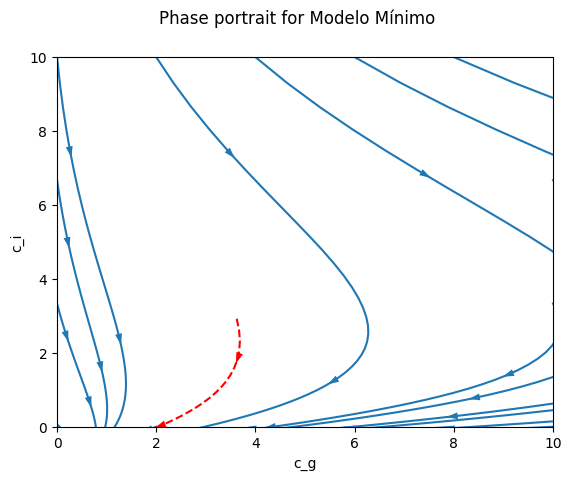

In [187]:
phase_plote_boundries = [0, 10, 0, 10]
ct.phase_plane_plot(dinamicaNormal, 
                    pointdata=phase_plote_boundries,
                    plot_streamlines=True,
                    plot_equilpoints=True,
                    plot_separatrices=True)

In [ ]:
respostaAoImpulso_dinamicaNormal = ct.step_response(dinamicaNormal, T=180, return_x=True)


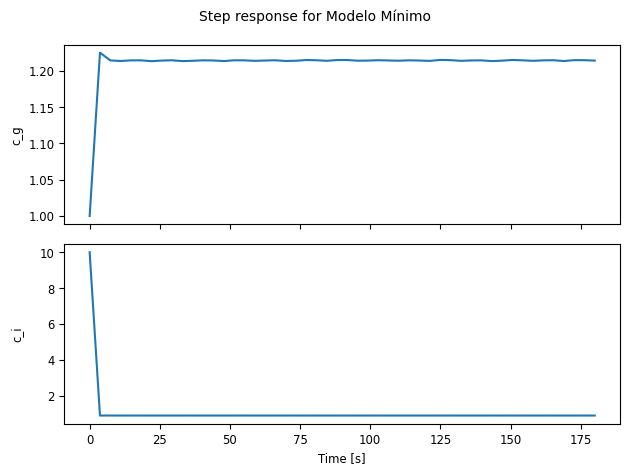

In [195]:
estado_inidial = [1, 10]

respostaAoDegrau_dinamicaNormal = ct.step_response(dinamicaNormal, T=180, return_x=True, X0=estado_inidial)

step_plots = ct.time_response_plot(respostaAoDegrau_dinamicaNormal)

In [190]:
ct.impulse_response

<function control.timeresp.impulse_response(sys, T=None, input=None, output=None, T_num=None, transpose=False, return_x=False, squeeze=None)>